<a href="https://colab.research.google.com/github/ilirsheraj/DUDL/blob/main/Chapter_06_regularization_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats("svg")

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

import seaborn as sns

# L2 Regularization

Also known as LASSO

In [4]:
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [5]:
# Load the Iris Dataset
data = torch.tensor(iris[iris.columns[0:4]].values).float()
# Tranform species to numbers
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=="setosa"] = 0
labels[iris.species=="versicolor"] = 1
labels[iris.species=="virginica"] = 2
labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2])

In [6]:
# Split the data and make it ready for training into batches
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Convert into PyTorch datasets
train_dataDataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataDataset = torch.utils.data.TensorDataset(test_data, test_labels)

# Create DataLoader Objects
train_loader = DataLoader(train_dataDataset, batch_size=64, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

In [7]:
# Define a function that creates an ANN model
def createANewModel(L2lambda):

    # Model Architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
        )
    
    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer (now we define L2 regularization as well)
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = 0.005, weight_decay=L2lambda)

    return ANNiris, lossfun, optimizer

In [8]:
# Train the model
numepochs = 1000

def trainTheModel():

    # Initialize the accuracies as empty lists
    trainAcc = []
    testAcc = []
    losses = []

    # Loop over the epochs
    for epochi in range(numepochs):

        # We can switch training mode here, but we dont need it for this model
        # ANNiris.train()

        # Loop over training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward pass and loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # BackProp
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Training Accuracy for this batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat, axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        # End of batch loop

        # Average training accuracy of batches
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Test Accuracy
        # The effect of turning on the eval() mode is two folds
        # IT TURNS OFF DROPO-OUT REGULARIZATION (WE ARE NOT DOING ANY DROPOUT IN THIS MODEL)
        # IT ALSO TURNS OFF BATCH NORMALIZATION, AND WE ARE NOT DOING BATCH NORMALIZATION HERE AS WELL
        # I am leaving it on here, but it will have no effect
        ANNiris.eval()
        # Extract X,y from test data
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X),axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())

        # We can reset the training mode here as well, doesnt have to be at the beginning of the loop all the time, dont need it in this case
        ANNiris.train()
    
    # Function's output
    return trainAcc, testAcc, losses

In [9]:
# Create a model
L2lambda = 0.01

ANNiris, lossfun, optimizer = createANewModel(L2lambda)

# Train the model
trainAcc, testAcc, losses = trainTheModel()

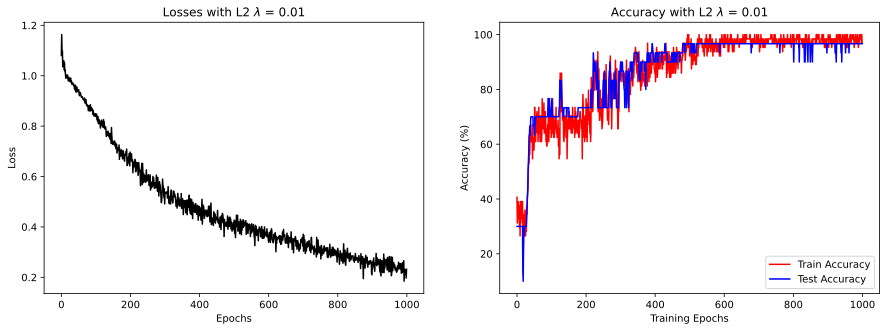

In [10]:
# Plot the results
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses, "k")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_title("Losses with L2 $\lambda$ = {}".format(L2lambda))

ax[1].plot(trainAcc, "r", label="Train Accuracy")
ax[1].plot(testAcc, "b", label="Test Accuracy")
ax[1].set_title("Accuracy with L2 $\lambda$ = {}".format(L2lambda))
ax[1].set_xlabel("Training Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()

plt.show()

## Experiment with Different $\lambda$ values

In [11]:
# Create a 1D Smoothing filter
def smooth(x,k=5):
    return np.convolve(x, np.ones(k)/k, mode="same")

In [20]:
# Define a range of lambda values
l2lambdas = np.linspace(0, 0.1, 10)

# initialize the output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(l2lambdas)))
accuracyResultsTest = np.zeros((numepochs, len(l2lambdas)))

# Loop over the lambdas
for li in range(len(l2lambdas)):

    # create a model and train it
    ANNiris, lossfun, optimizer = createANewModel(l2lambdas[li])
    trainAcc, testAcc, losses = trainTheModel()

    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li] = smooth(testAcc, 10)

In [21]:
accuracyResultsTrain[995:, :]

array([[97.65625, 98.4375 , 98.4375 , 97.03125, 97.03125, 97.8125 ,
        98.125  , 97.1875 , 96.875  , 93.4375 ],
       [87.96875, 88.59375, 88.75   , 87.1875 , 87.1875 , 87.96875,
        88.4375 , 87.5    , 87.1875 , 84.0625 ],
       [78.28125, 78.75   , 78.75   , 77.5    , 77.5    , 78.125  ,
        78.59375, 77.8125 , 77.1875 , 74.53125],
       [68.4375 , 68.90625, 68.75   , 67.65625, 67.8125 , 68.28125,
        68.75   , 67.96875, 67.65625, 65.625  ],
       [58.4375 , 59.0625 , 58.90625, 58.125  , 58.125  , 58.4375 ,
        58.75   , 58.28125, 57.8125 , 56.25   ]])

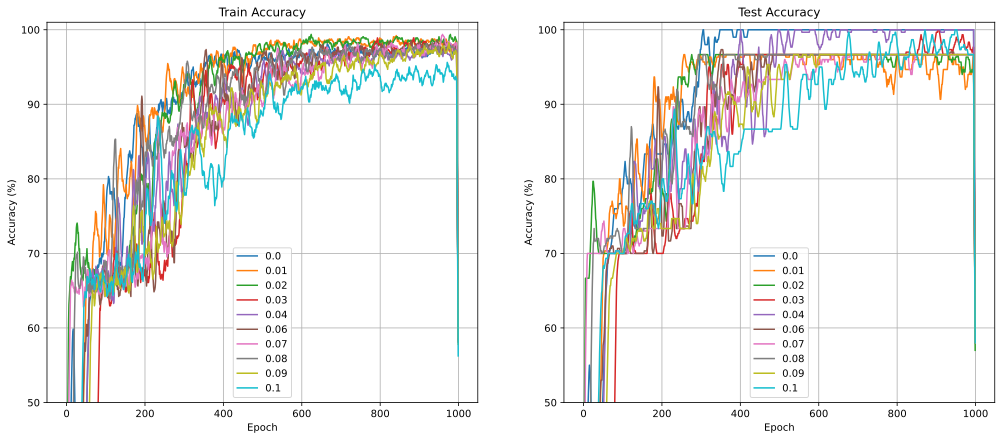

In [22]:
# plot the whole thing
fig, ax = plt.subplots(1,2, figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title("Train Accuracy")
ax[1].plot(accuracyResultsTest)
ax[1].set_title("Test Accuracy")

# Make the lgend easier to read
leglabels = [np.round(i,2) for i in l2lambdas]

# Common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

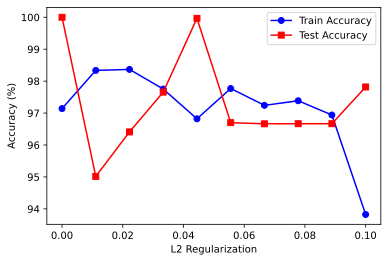

In [24]:
# Show the average accuracy by L2 rate
# Take only the last 500 epochs
epoch_range = [850, 950]

plt.plot(l2lambdas, 
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:], axis=0), "bo-", label = "Train Accuracy")

plt.plot(l2lambdas, 
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:], axis=0), "rs-", label = "Test Accuracy")
plt.ylabel("Accuracy (%)")
plt.xlabel("L2 Regularization")
plt.legend()
plt.show()

# L1 Regularization

In [26]:
# Here we will use iris dataset, so the processing and converting to dataloader is the same
# The DL model architecture is also the same except that we do not import L2 in optimizer
# Define a function that creates an ANN model

def createANewModel():

    # Model Architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
        )
    
    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer: We specify nothing for weight decay argument
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = 0.005)

    return ANNiris, lossfun, optimizer

In [27]:
# Explore the model
tmpmodel = createANewModel()[0]

print(tmpmodel)

Sequential(
  (0): Linear(in_features=4, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=3, bias=True)
)


In [28]:
# Print the model's parameters
for i in tmpmodel.named_parameters():
    print(i[0],i[1].shape, i[1].numel())
# 1 and 3 is skipped because of ReLU(). IT HAS NO PARAMETERS

0.weight torch.Size([64, 4]) 256
0.bias torch.Size([64]) 64
2.weight torch.Size([64, 64]) 4096
2.bias torch.Size([64]) 64
4.weight torch.Size([3, 64]) 192
4.bias torch.Size([3]) 3


In [29]:
# Train the model
# Global paameter
numepochs = 1000

def trainTheModel(L1lambda):

    # Initialize accuracies as empty lists
    trainAcc = []
    testAcc = []
    losses = []

    # Count the total number of weights in the model (biases are not inclded here)
    nweights = 0
    for pname, weight in ANNiris.named_parameters():
        if "bias" not in pname:
            nweights = nweights + weight.numel()

    # Loop over epochs
    for epochi in range(numepochs):

        # Loop over training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward Pass and Loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # Add L1 term (initialize it to be zero)
            L1_term = torch.tensor(0., requires_grad=True)

            # Sum up all abs(weights)
            for pname, weight in ANNiris.named_parameters():
                if "bias" not in pname:
                    L1_term = L1_term + torch.sum(torch.abs(weight))

            # Add to the loss term (We need the L1 regularizer here to reduce the effect of L1_term)
            loss = loss + L1lambda*L1_term/nweights

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute the training accuracy for a single batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        # End of batch loop
        # Average training accuracy for the batches
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Testing
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())

    # Function output
    return trainAcc, testAcc, losses

In [30]:
# Test the model once
ANNiris, lossfun, optimizer = createANewModel()

# Train the Model
L1lambda = 0.001
trainAcc, tesAcc, losses = trainTheModel(L1lambda)

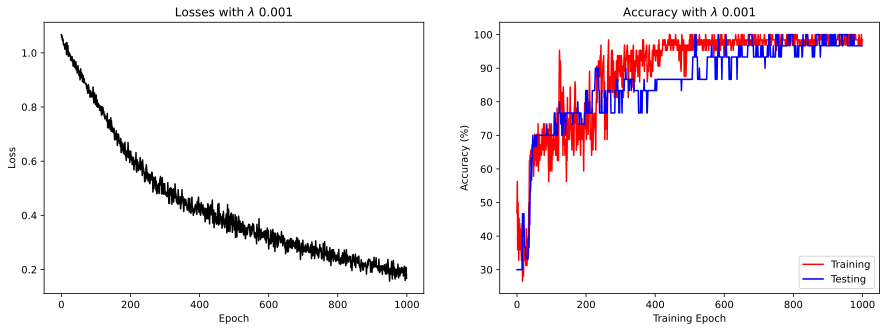

In [31]:
# Plot the results
fig, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses, "k")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses with $\lambda$ {}".format(L1lambda))

ax[1].plot(trainAcc, "r", label = "Training")
ax[1].plot(testAcc, "b", label = "Testing")
ax[1].set_title("Accuracy with $\lambda$ {}".format(L1lambda))
ax[1].set_xlabel("Training Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].legend()

plt.show()

In [32]:
# Create a 1D Smoothing filter
def smooth(x,k):
    return np.convolve(x, np.ones(k)/k, mode="same")

In [33]:
# Define a range of lambda values
L1lambda = np.linspace(0, 0.005, 10)

# initialize the output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(L1lambda)))
accuracyResultsTest = np.zeros((numepochs, len(L1lambda)))

# Loop over the lambdas
for li in range(len(L1lambda)):

    # create a model and train it
    ANNiris, lossfun, optimizer = createANewModel()
    trainAcc, testAcc, losses = trainTheModel(L1lambda[li])

    accuracyResultsTrain[:,li] = smooth(trainAcc,10)
    accuracyResultsTest[:,li] = smooth(testAcc, 10)

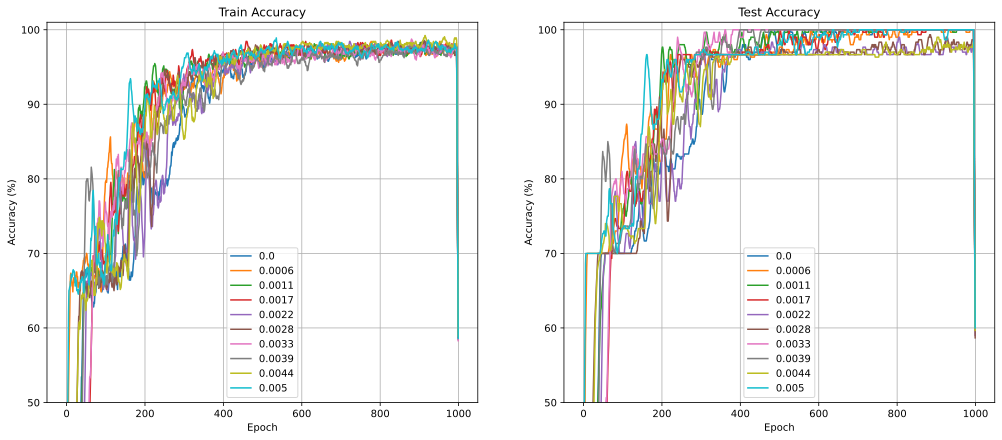

In [34]:
# plot the whole thing
fig, ax = plt.subplots(1,2, figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title("Train Accuracy")
ax[1].plot(accuracyResultsTest)
ax[1].set_title("Test Accuracy")

# Make the lgend easier to read
leglabels = [np.round(i,4) for i in L1lambda]

# Common features
for i in range(2):
    ax[i].legend(leglabels)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([50,101])
    ax[i].grid()

plt.show()

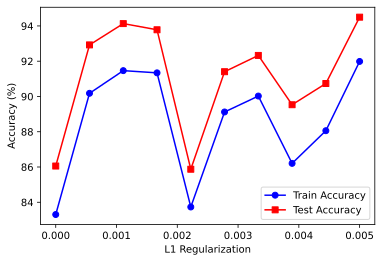

In [35]:
# Which lambda facilitates early learning
epoch_range = [160, 360]

plt.plot(L1lambda, 
         np.mean(accuracyResultsTrain[epoch_range[0]:epoch_range[1],:], axis=0), "bo-", label = "Train Accuracy")

plt.plot(L1lambda, 
         np.mean(accuracyResultsTest[epoch_range[0]:epoch_range[1],:], axis=0), "rs-", label = "Test Accuracy")
plt.ylabel("Accuracy (%)")
plt.xlabel("L1 Regularization")
plt.legend()
plt.show()

# Train in MiniBatches

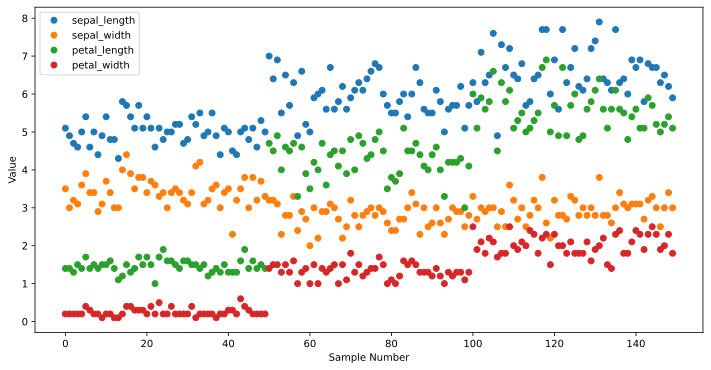

In [36]:
# We will use iris again
iris.plot(marker="o", linestyle="none", figsize=(12,6))
plt.xlabel("Sample Number")
plt.ylabel("Value")
plt.show()

In [37]:
# Split the data and make it ready for training into batches
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Convert into PyTorch datasets
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# Create DataLoader Objects
# drop_last to remove the last minibatch when number is not complete
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [38]:
# Check btches for data batches
for X,y in train_loader:
    print(X.shape, y.shape)

torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])
torch.Size([16, 4]) torch.Size([16])


In [39]:
# Construct the model
def createANewModel():

    # Model Architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
        )
    
    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer (now we define L2 regularization as well)
    # Give small lr to see some variability in model learning
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = 0.0005)

    return ANNiris, lossfun, optimizer

In [40]:
# Train the model
# Global paameter
numepochs = 500

def trainTheModel():

    # Initialize accuracies as empty lists
    trainAcc = []
    testAcc = []
    losses = []

    # Loop over epochs
    for epochi in range(numepochs):

        # Loop over training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward Pass and Loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute the training accuracy for a single batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        # End of batch loop
        # Average training accuracy for the batches
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Testing
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())

    # Function output
    return trainAcc, testAcc, losses

In [41]:
# Create a model
ANNiris, lossfun, optimizer = createANewModel()
trainAcc, testAcc, losses = trainTheModel()

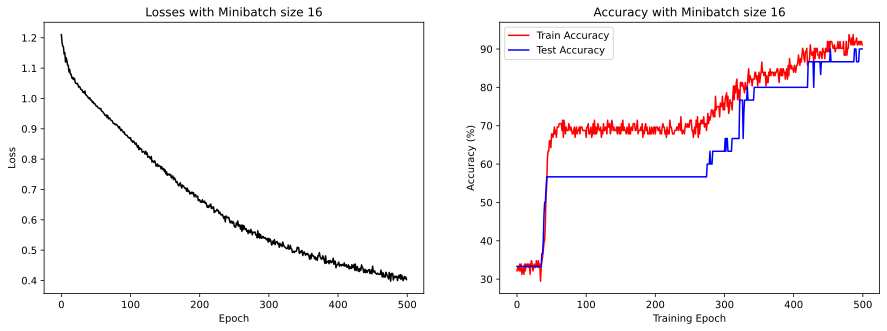

In [42]:
# Plot the results

fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses, "k")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses with Minibatch size {}".format(batchsize))

ax[1].plot(trainAcc, "r", label= "Train Accuracy")
ax[1].plot(testAcc, "b", label = "Test Accuracy")
ax[1].set_xlabel("Training Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Accuracy with Minibatch size {}".format(batchsize))
ax[1].legend()

plt.show()
# Very small learning rate, takes long to converge. 
# Slowing lr gives an opportunity to see whats going on

## Decrease Batch Size

In [43]:
batchsize = 4
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True) # drop_last to remove the last minibatch
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [44]:
# Train the model
# Global paameter
numepochs = 500

def trainTheModel():

    # Initialize accuracies as empty lists
    trainAcc = []
    testAcc = []
    losses = []

    # Loop over epochs
    for epochi in range(numepochs):

        # Loop over training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward Pass and Loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute the training accuracy for a single batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        # End of batch loop
        # Average training accuracy for the batches
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Testing
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())

    # Function output
    return trainAcc, testAcc, losses

In [ ]:
ANNiris, lossfun, optimizer = createANewModel()
trainAcc, testAcc, losses = trainTheModel()

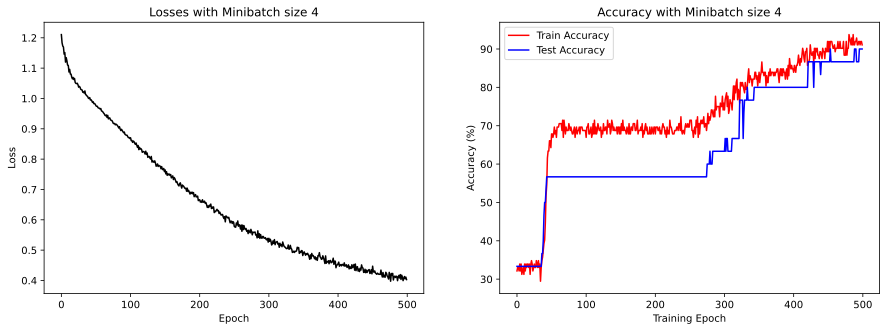

In [45]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses, "k")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses with Minibatch size {}".format(batchsize))

ax[1].plot(trainAcc, "r", label= "Train Accuracy")
ax[1].plot(testAcc, "b", label = "Test Accuracy")
ax[1].set_xlabel("Training Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Accuracy with Minibatch size {}".format(batchsize))
ax[1].legend()

plt.show()
# Model learns faster

## Higher Batch Size

In [46]:
batchsize = 54
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True) # drop_last to remove the last minibatch
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [47]:
numepochs = 2500

def trainTheModel():

    # Initialize accuracies as empty lists
    trainAcc = []
    testAcc = []
    losses = []

    # Loop over epochs
    for epochi in range(numepochs):

        # Loop over training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward Pass and Loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute the training accuracy for a single batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        # End of batch loop
        # Average training accuracy for the batches
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Testing
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())

    # Function output
    return trainAcc, testAcc, losses

In [48]:
ANNiris, lossfun, optimizer = createANewModel()
trainAcc, testAcc, losses = trainTheModel()

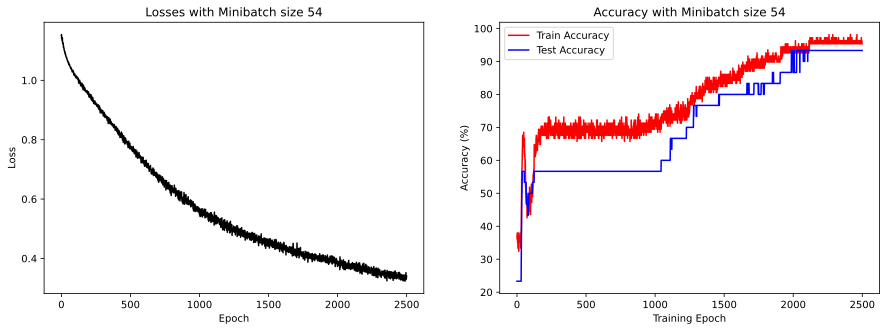

In [49]:
fig,ax = plt.subplots(1,2, figsize=(15,5))

ax[0].plot(losses, "k")
ax[0].set_ylabel("Loss")
ax[0].set_xlabel("Epoch")
ax[0].set_title("Losses with Minibatch size {}".format(batchsize))

ax[1].plot(trainAcc, "r", label= "Train Accuracy")
ax[1].plot(testAcc, "b", label = "Test Accuracy")
ax[1].set_xlabel("Training Epoch")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title("Accuracy with Minibatch size {}".format(batchsize))
ax[1].legend()

plt.show()
# Very fast, but accuracy sucks unless training epochs are significantly increased

# Test Batch Size

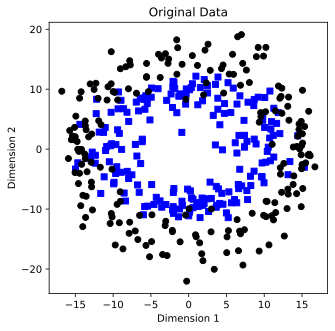

In [50]:
# create data
nPerClust = 200

th = np.linspace(0,4*np.pi,nPerClust)
r1 = 10
r2 = 15

# generate data
a = [ r1*np.cos(th) + np.random.randn(nPerClust)*3 ,
      r1*np.sin(th) + np.random.randn(nPerClust) ]
b = [ r2*np.cos(th) + np.random.randn(nPerClust) ,
      r2*np.sin(th) + np.random.randn(nPerClust)*3 ]

# true labels
labels_np = np.vstack((np.zeros((nPerClust,1)),np.ones((nPerClust,1))))

# concatanate into a matrix
data_np = np.hstack((a,b)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).float()

# show the data
fig = plt.figure(figsize=(5,5))
plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs')
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko')
plt.title("Original Data")
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

In [51]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
train_batchsize = 16
# We dont want to have minibatches for test, but this time we introduce -2
test_batchsize  = test_data.tensors[0].shape[0]-2
train_loader = DataLoader(train_data,batch_size=train_batchsize,shuffle=True,drop_last=True)
# test batch size
test_loader  = DataLoader(test_data,batch_size=test_batchsize)

In [52]:
# check sizes of data batches
for X,y in test_loader:
    print(X.shape,y.shape)

torch.Size([38, 2]) torch.Size([38, 1])
torch.Size([2, 2]) torch.Size([2, 1])


In [53]:
class theModelClass(nn.Module):
    def __init__(self):
        super().__init__()

        ### layers
        self.input  = nn.Linear(  2,128)
        self.hidden = nn.Linear(128,128)
        self.output = nn.Linear(128, 1)

    # forward pass
    def forward(self,x):
        x = F.relu( self.input(x) )
        x = F.relu( self.hidden(x) )
        x = self.output(x)
        return x

In [54]:
def createANewModel():

    # grab an instance of the model class
    ANNQC = theModelClass()

    # loss function
    lossfun = nn.BCEWithLogitsLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANNQC.parameters(),lr=.01)

    return ANNQC,lossfun,optimizer

In [55]:
# Train the model
# global parameter
numepochs = 500

def trainTheModel(ANNQC,lossfun,optimizer):

    # initialize accuracies as empties (not storing losses here)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(numepochs):

        # loop over training data batches
        batchAcc = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = ANNQC(X)
            loss = lossfun(yHat,y)
            
            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # compute training accuracy just for this batch
            batchAcc.append( 100*torch.mean(((yHat>0)==y).float()).item() )
        # end of batch loop...
        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.mean(batchAcc) )

        # test accuracy (NOTE: testing in batches!)
        tstacc = []
        # Accuracy of only two samples, thus the craziness in accuracy (0, 50 0r 100%)
        for X,y in test_loader:
            yHat = ANNQC(X)
            tstacc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
        # now get the average accuracy over test-batches
        testAcc.append(np.mean(tstacc))
    
    # function output
    return trainAcc,testAcc

In [56]:
# create a model
ANNQC,lossfun,optimizer = createANewModel()

# train the model (note the inputs!)
trainAcc,testAcc = trainTheModel(ANNQC,lossfun,optimizer)

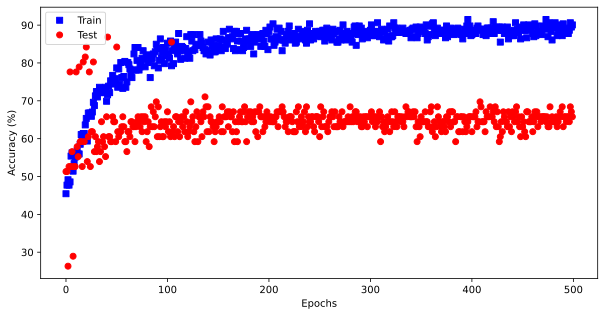

In [57]:
# plot the results
fig = plt.figure(figsize=(10,5))

plt.plot(trainAcc,'bs')
plt.plot(testAcc,'ro')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend(['Train','Test'])

plt.show()

If we make the test batch as single, we sont see these separate test ccuracies

# Code Challenge

In [59]:
# Perform a parametric Experiment to explore minibatch size on model performance
# Set minibatch sizes of 2^N for N = 1,...,6
# Set the learning rate 0.001
# Store resulting train and test accuracy over epochs for each batch size

# Construct the model
def createANewModel():

    # Model Architecture
    ANNiris = nn.Sequential(
        nn.Linear(4,64),
        nn.ReLU(),
        nn.Linear(64,64),
        nn.ReLU(),
        nn.Linear(64,3),
        )
    
    # Define the loss function
    lossfun = nn.CrossEntropyLoss()

    # Optimizer (now we define L2 regularization as well)
    optimizer = torch.optim.SGD(ANNiris.parameters(), lr = 0.0005)

    return ANNiris, lossfun, optimizer

In [60]:
# Global paameter
numepochs = 1000

def trainTheModel():

    # Initialize accuracies as empty lists
    trainAcc = []
    testAcc = []
    losses = []

    # Loop over epochs
    for epochi in range(numepochs):

        # Loop over training data batches
        batchAcc = []
        batchLoss = []

        for X,y in train_loader:

            # Forward Pass and Loss
            yHat = ANNiris(X)
            loss = lossfun(yHat,y)

            # Back Propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Compute the training accuracy for a single batch
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
        # End of batch loop
        # Average training accuracy for the batches
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))

        # Testing
        X,y = next(iter(test_loader))
        predlabels = torch.argmax(ANNiris(X), axis=1)
        testAcc.append(100*torch.mean((predlabels == y).float()).item())

    # Function output
    return trainAcc, testAcc, losses

In [61]:
# Load the Iris Dataset
data = torch.tensor(iris[iris.columns[0:4]].values).float()
# Tranform species to numbers
labels = torch.zeros(len(data), dtype=torch.long)
labels[iris.species=="setosa"] = 0
labels[iris.species=="versicolor"] = 1
labels[iris.species=="virginica"] = 2

# Split the data into train-test and convert to dataloader
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2)

# Convert to PyTorch datasets
train_data = torch.utils.data.TensorDataset(train_data, train_labels)
test_data = torch.utils.data.TensorDataset(test_data, test_labels)

In [62]:
# range of batch sizes
batchsizes = 2**np.arange(1,7)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs,len(batchsizes)))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_data,batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

    # create dataloader object
    train_loader = DataLoader(train_data, batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

    # create and train a model
    ANNiris,lossfun,optimizer = createANewModel()
    trainAcc,testAcc,losses = trainTheModel()

    # store results
    accuracyResultsTrain[:,bi] = trainAcc
    accuracyResultsTest[:,bi]  = testAcc

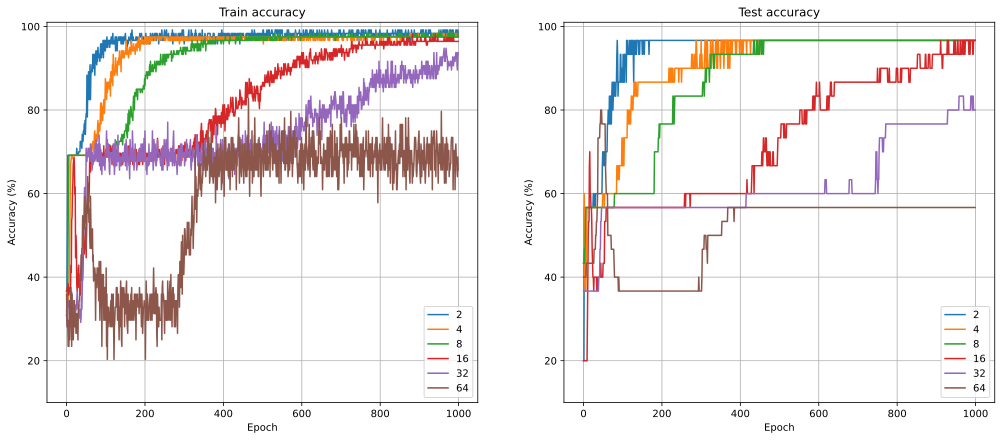

In [63]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(17,7))

ax[0].plot(accuracyResultsTrain)
ax[0].set_title("Train accuracy")
ax[1].plot(accuracyResultsTest)
ax[1].set_title("Test accuracy")

# common features
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Accuracy (%)")
    ax[i].set_ylim([10,101])
    ax[i].grid()

plt.show()